In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import os
from scipy import ndimage

## VTK reader

In [12]:
import vtk
from vtk.util.numpy_support import vtk_to_numpy
from scipy.interpolate import griddata
import matplotlib.cm as cm
from collections.abc import Iterable

In [13]:
def read_vtk(file_name, filetype="vtu", *args):
    """Read the data in vtk/vtu/vtp files
    Return a dictionary containing 'mesh' and other physics field data in numpy form
    """
    
    reader = vtk.vtkXMLUnstructuredGridReader()
    if filetype =="vtp":
        reader = vtk.vtkXMLPolyDataReader()
    
    reader.SetFileName(file_name)
    reader.Update()  # Needed because of GetScalarRange
    output = reader.GetOutput()
    
    # Get the field data
    vtk_array_dict = dict()
    numpy_array_dict = dict()
    
    field_names = [item for item in args]

    while isinstance(field_names[0], list):
        field_names = [item for item in field_names[0]]
    
    # Get the mesh data
    nodes_vtk_array= reader.GetOutput().GetPoints().GetData()
    numpy_array_dict['mesh'] = vtk_to_numpy(nodes_vtk_array)
    
    for name in field_names:
        vtk_array_dict[name] = output.GetPointData().GetArray(name)
        numpy_array_dict[name] = vtk_to_numpy(output.GetPointData().GetArray(name))

    return numpy_array_dict


## PIV image generator

In [14]:
def kernal_generator(n=1):
    """Generate the kernal matrix"""
    kernal = []
    size = (2*n+1)*(2*n+1)
    # ind_x * (2*n+1) + ind_y = i
    for i in range(size):
        ind_x = np.floor(i / (2*n+1))
        ind_y = i % (2*n+1)
        kernal.append([int(ind_x-n),int(ind_y-n)])
    return kernal

In [15]:
def PIV_generator(node_array, size=(450,180), ranges=[[0.5, 1.5],[0.0,0.6]], dp=2.81, kernal_size=1, noise=False):
    node_mat = np.zeros(size)
    
    """Function used to generate particle images from vtk files"""
    
    fail = 0
    node_new = node_array * size[0]/1.5
    
    # Calculate the kernal matrix
    kernal = kernal_generator(kernal_size)
    
    
    for x_0,y_0 in np.floor(node_new)[:,0:2]:
        if int(x_0) >= size[0]:
            x_0 = size[0]-1
            fail += 1
        if int(y_0) >= size[1]:
            y_0 = size[1]-1
            fail += 1
        
        id_x = int(x_0)
        id_y = int(y_0)
        
        for ind in kernal:
            if id_x+ind[0] < 0 or id_x+ind[0] >= size[0] or id_y+ind[1] < 0 or id_y+ind[1] >= size[1]:
                fail += 1
                continue
            else:
                node_mat[id_x, id_y] += gauss_2d(ind[0], ind[1], dp=dp)

    if noise:
        thr = 0.8*np.max(node_mat)
        #print(thr)
        # Add some noise
        for i in range(size[0]):
            for j in range(size[1]):
                if  np.random.uniform(0.0, 1.0) < 0.05 and  node_mat[i,j] < thr:
                    node_mat[i,j] += np.random.uniform(0.01, thr)
    
    print("Particle density: ", len(np.where(node_mat!=0)[0])/(size[0]*size[1]))
    print("Out of boundary numbers: ", fail)
    return (node_mat[int(size[0]*ranges[0][0]/1.5):int(size[0]*ranges[0][1]/1.5), \
                    int(size[1]*ranges[1][0]/0.6):int(size[1]*ranges[1][1]/0.6)]).T


In [16]:
def gauss_2d(dx, dy, dp=2.81, I_0=1.0):
    return I_0*np.exp(8*(-np.power(dx,2.0)-np.power(dy,2.0))/(dp*dp))

## Field Interpolation

In [17]:
def interpolate_field(data, ranges=None, x_points=100, dim=2):
    """Do interpolation in the field using the mesh point data
    to make the a complete data matrix
    2D interpolation is developed now, there are three components:
    vx, vy, v_magnitude
    """
    
    field_names = [item for item in data.keys()].pop()
    while not isinstance(field_names, list):
        field_names = [field_names]
    
    if ranges is None:
        xmin, xmax = min(x), max(x)
        ymin, ymax = min(y), max(y)
    else:
        xmin, xmax = ranges[0][0], ranges[0][1]
        ymin, ymax = ranges[1][0], ranges[1][1]
    
    npts_x = x_points
    npts_y = np.floor(npts_x * (ymax - ymin) / (xmax - xmin))
    # define grid
    xi = np.linspace(xmin, xmax, npts_x)
    yi = np.linspace(ymin, ymax, npts_y)
        
    x,y,z= data['mesh'][:,0] , data['mesh'][:,1] , data['mesh'][:,2]
    
    field_value_dict = dict()
    if dim==2:
        # 2D interpolate
        for name in field_names:
            size = data[name].shape
            data_components = []
            for i in range(size[1]-1):
                data_components.append(griddata((x, y), data[name][:,i], (xi[None,:], yi[:,None]), method='cubic'))

            magnitude = np.sqrt(np.power(data[name][:,0],2) + np.power(data[name][:,1],2))
            data_components.append(griddata((x, y), magnitude, (xi[None,:], yi[:,None]), method='cubic'))
            field_value_dict[name] = data_components   
    else:
        print("Under construction")
    return field_value_dict

## Read and process all CFD data

In [9]:
Re = 2300
Re_num = 'Re'+str(Re)+'_DH2'

Re_factor = 2300.0 / Re 

start_frame = int(65 * Re_factor)
end_frame = start_frame + 60 - 1

In [91]:
# Define the data holder
vx_field = []
vy_field = []
vm_field = []
vxy_field = []

field_name = "Depth averaged velocity"
for i in range(start_frame, end_frame+1):
    file_name = "../vel_source/"+Re_num+"/Velocity2d/Velocity2d_%d.vtu"%i
    data = read_vtk(file_name, "vtu", field_name)
    field_value = interpolate_field(data, ranges=[[0.5, 1.5],[0.0,0.6]], x_points=300)
    vx_field.append(field_value[field_name][0])
    vy_field.append(field_value[field_name][1]) 
    vm_field.append(field_value[field_name][2])
    vxy_field.append([field_value[field_name][0], field_value[field_name][1]])
    print("Finished ",i+1-start_frame, " frame. The frame size is ", vm_field[i-start_frame].shape)
ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y_%m_%d_%H_%M_%S')
output_path = "../data/vel_data/"+Re_num
try:
    os.mkdir(output_path)
except FileExistsError:
    print('file exist')
output_path = "../data/vel_data/"+Re_num+"/labels"#+st
try:
    os.mkdir(output_path)
except FileExistsError:
    print('file exist')
np.save(output_path + "/vx_field", np.array(vx_field))
np.save(output_path + "/vy_field", np.array(vy_field))
np.save(output_path + "/vm_field", np.array(vm_field))
np.save(output_path + "/vm_label", 0.5*(np.array(vm_field)[1:]+np.array(vm_field)[:-1]))
np.save(output_path + "/vxy_label", np.array(vxy_field))

/Users/zmr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


Finished  1  frame. The frame size is  (180, 300)
Finished  2  frame. The frame size is  (180, 300)
Finished  3  frame. The frame size is  (180, 300)
Finished  4  frame. The frame size is  (180, 300)
Finished  5  frame. The frame size is  (180, 300)
Finished  6  frame. The frame size is  (180, 300)
Finished  7  frame. The frame size is  (180, 300)
Finished  8  frame. The frame size is  (180, 300)
Finished  9  frame. The frame size is  (180, 300)
Finished  10  frame. The frame size is  (180, 300)
Finished  11  frame. The frame size is  (180, 300)
Finished  12  frame. The frame size is  (180, 300)
Finished  13  frame. The frame size is  (180, 300)
Finished  14  frame. The frame size is  (180, 300)
Finished  15  frame. The frame size is  (180, 300)
Finished  16  frame. The frame size is  (180, 300)
Finished  17  frame. The frame size is  (180, 300)
Finished  18  frame. The frame size is  (180, 300)
Finished  19  frame. The frame size is  (180, 300)
Finished  20  frame. The frame size is  

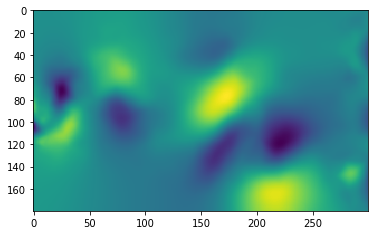

In [67]:
plt.imshow(np.array(vm_field)[4])

## Read and process all particle data

In [92]:
dp_set = [2.0, 3.0, 3.8]

if Re == 1150:
    insert_rate_set = [5, 12, 25, 50]
if Re == 2300:
    insert_rate_set = [10, 25]
if Re == 3450:
    insert_rate_set = [15, 38, 75, 150]
if Re == 4600:
    insert_rate_set = [20, 50, 100, 200]


In [93]:
for insert_rate in insert_rate_set:
    for dp in dp_set:
        # The source file
        particle_position = []
        pair = []
        field_name = "Particle Velocity"

        # diameter of paticle pixels/particle
        noise = False
        if noise:
            noise_str = "yes"
        else:
            noise_str = "no"
        dp = dp
        #start_frame = 65
        #end_frame = 500

        stopwatch = 0
        for i in range(start_frame, end_frame+1):
            file_name = "../vel_source/"+Re_num+"/particles%dps/Velocity2d.pvd_%d.vtp"%(insert_rate, i)
            
            data = read_vtk(file_name, "vtp", field_name)

            pair.append(PIV_generator(data['mesh'],dp=dp,noise=noise))
            if stopwatch == 1:
                particle_position.append(np.array(pair))
                pair.pop(0)
                stopwatch = 0
            stopwatch += 1
            print("Finished ",i+1-start_frame, " frame.") # The frame size is ", particle_position[i-65].shape)

        ts = time.time()
        st = datetime.datetime.fromtimestamp(ts).strftime('%Y_%m_%d_%H_%M_%S')
        try:
            output_path = "./veloc_data/"+Re_num
            os.mkdir(output_path)
        except:
            output_path = "./veloc_data/"+Re_num+"/traindata_dp%.2f_ir%d"%(dp, insert_rate)#+st
            os.mkdir(output_path)
        np.save(output_path + "/particle_positions", np.array(particle_position))
        with open(output_path+"/Parameters.txt",'w') as file:
            file.write("Dataset size: "+ str(np.array(particle_position).shape)+"\n"+
                       "Paticle diameter: "+ str(dp)+"\n"+
                       "Insert Rate: "+str(insert_rate)+"\n"+
                       "Particle Density: "+str(insert_rate*65/(450*180))+"\n"+
                       "Noise:"+ noise_str)
        print("Particle Diameter: ", dp, " Finished.")
    print("Insert Rate: ", insert_rate, " Finished.")

Particle density:  0.007703703703703704
Out of boundary numbers:  533
Finished  1  frame.
Particle density:  0.007839506172839506
Out of boundary numbers:  542
Finished  2  frame.
Particle density:  0.007753086419753087
Out of boundary numbers:  545
Finished  3  frame.
Particle density:  0.0077777777777777776
Out of boundary numbers:  548
Finished  4  frame.
Particle density:  0.0077777777777777776
Out of boundary numbers:  542
Finished  5  frame.
Particle density:  0.007864197530864198
Out of boundary numbers:  548
Finished  6  frame.
Particle density:  0.00788888888888889
Out of boundary numbers:  530
Finished  7  frame.
Particle density:  0.007987654320987655
Out of boundary numbers:  539
Finished  8  frame.
Particle density:  0.007975308641975308
Out of boundary numbers:  548
Finished  9  frame.
Particle density:  0.00791358024691358
Out of boundary numbers:  530
Finished  10  frame.
Particle density:  0.007740740740740741
Out of boundary numbers:  542
Finished  11  frame.
Particle

Particle density:  0.007802469135802469
Out of boundary numbers:  524
Finished  31  frame.
Particle density:  0.0077901234567901234
Out of boundary numbers:  533
Finished  32  frame.
Particle density:  0.007753086419753087
Out of boundary numbers:  526
Finished  33  frame.
Particle density:  0.007753086419753087
Out of boundary numbers:  527
Finished  34  frame.
Particle density:  0.007753086419753087
Out of boundary numbers:  521
Finished  35  frame.
Particle density:  0.007802469135802469
Out of boundary numbers:  518
Finished  36  frame.
Particle density:  0.007851851851851851
Out of boundary numbers:  518
Finished  37  frame.
Particle density:  0.007851851851851851
Out of boundary numbers:  527
Finished  38  frame.
Particle density:  0.007925925925925927
Out of boundary numbers:  527
Finished  39  frame.
Particle density:  0.007876543209876543
Out of boundary numbers:  521
Finished  40  frame.
Particle density:  0.007987654320987655
Out of boundary numbers:  539
Finished  41  frame

Particle density:  0.01897530864197531
Out of boundary numbers:  572
Finished  2  frame.
Particle density:  0.019024691358024693
Out of boundary numbers:  560
Finished  3  frame.
Particle density:  0.019
Out of boundary numbers:  560
Finished  4  frame.
Particle density:  0.019037037037037036
Out of boundary numbers:  569
Finished  5  frame.
Particle density:  0.019098765432098767
Out of boundary numbers:  563
Finished  6  frame.
Particle density:  0.018876543209876542
Out of boundary numbers:  575
Finished  7  frame.
Particle density:  0.018765432098765432
Out of boundary numbers:  569
Finished  8  frame.
Particle density:  0.01888888888888889
Out of boundary numbers:  557
Finished  9  frame.
Particle density:  0.018901234567901236
Out of boundary numbers:  560
Finished  10  frame.
Particle density:  0.019037037037037036
Out of boundary numbers:  557
Finished  11  frame.
Particle density:  0.018962962962962963
Out of boundary numbers:  554
Finished  12  frame.
Particle density:  0.018

Particle density:  0.018938271604938273
Out of boundary numbers:  560
Finished  34  frame.
Particle density:  0.019
Out of boundary numbers:  580
Finished  35  frame.
Particle density:  0.01906172839506173
Out of boundary numbers:  578
Finished  36  frame.
Particle density:  0.01906172839506173
Out of boundary numbers:  575
Finished  37  frame.
Particle density:  0.019148148148148147
Out of boundary numbers:  574
Finished  38  frame.
Particle density:  0.019271604938271604
Out of boundary numbers:  584
Finished  39  frame.
Particle density:  0.019148148148148147
Out of boundary numbers:  581
Finished  40  frame.
Particle density:  0.01925925925925926
Out of boundary numbers:  593
Finished  41  frame.
Particle density:  0.01928395061728395
Out of boundary numbers:  590
Finished  42  frame.
Particle density:  0.019246913580246914
Out of boundary numbers:  569
Finished  43  frame.
Particle density:  0.019271604938271604
Out of boundary numbers:  577
Finished  44  frame.
Particle density: 

Particle density:  0.03949382716049383
Out of boundary numbers:  650
Finished  4  frame.
Particle density:  0.0394320987654321
Out of boundary numbers:  647
Finished  5  frame.
Particle density:  0.03950617283950617
Out of boundary numbers:  662
Finished  6  frame.
Particle density:  0.03939506172839506
Out of boundary numbers:  635
Finished  7  frame.
Particle density:  0.03927160493827161
Out of boundary numbers:  655
Finished  8  frame.
Particle density:  0.039691358024691356
Out of boundary numbers:  662
Finished  9  frame.
Particle density:  0.039753086419753086
Out of boundary numbers:  668
Finished  10  frame.
Particle density:  0.03974074074074074
Out of boundary numbers:  650
Finished  11  frame.
Particle density:  0.03988888888888889
Out of boundary numbers:  662
Finished  12  frame.
Particle density:  0.03977777777777778
Out of boundary numbers:  662
Finished  13  frame.
Particle density:  0.04006172839506173
Out of boundary numbers:  668
Finished  14  frame.
Particle densit

Particle density:  0.038691358024691355
Out of boundary numbers:  692
Finished  35  frame.
Particle density:  0.03891358024691358
Out of boundary numbers:  680
Finished  36  frame.
Particle density:  0.038703703703703705
Out of boundary numbers:  689
Finished  37  frame.
Particle density:  0.038296296296296294
Out of boundary numbers:  689
Finished  38  frame.
Particle density:  0.038419753086419754
Out of boundary numbers:  680
Finished  39  frame.
Particle density:  0.038037037037037036
Out of boundary numbers:  662
Finished  40  frame.
Particle density:  0.03818518518518518
Out of boundary numbers:  704
Finished  41  frame.
Particle density:  0.03824691358024691
Out of boundary numbers:  674
Finished  42  frame.
Particle density:  0.03828395061728395
Out of boundary numbers:  683
Finished  43  frame.
Particle density:  0.038407407407407404
Out of boundary numbers:  677
Finished  44  frame.
Particle density:  0.03788888888888889
Out of boundary numbers:  686
Finished  45  frame.
Part

Particle density:  0.07676543209876543
Out of boundary numbers:  857
Finished  6  frame.
Particle density:  0.07696296296296297
Out of boundary numbers:  861
Finished  7  frame.
Particle density:  0.07692592592592593
Out of boundary numbers:  868
Finished  8  frame.
Particle density:  0.07733333333333334
Out of boundary numbers:  881
Finished  9  frame.
Particle density:  0.07787654320987654
Out of boundary numbers:  881
Finished  10  frame.
Particle density:  0.07779012345679012
Out of boundary numbers:  881
Finished  11  frame.
Particle density:  0.07777777777777778
Out of boundary numbers:  833
Finished  12  frame.
Particle density:  0.07817283950617283
Out of boundary numbers:  902
Finished  13  frame.
Particle density:  0.07791358024691358
Out of boundary numbers:  906
Finished  14  frame.
Particle density:  0.07772839506172839
Out of boundary numbers:  893
Finished  15  frame.
Particle density:  0.07782716049382717
Out of boundary numbers:  886
Finished  16  frame.
Particle densi

Particle density:  0.07593827160493827
Out of boundary numbers:  803
Finished  37  frame.
Particle density:  0.07579012345679012
Out of boundary numbers:  848
Finished  38  frame.
Particle density:  0.07619753086419753
Out of boundary numbers:  821
Finished  39  frame.
Particle density:  0.07593827160493827
Out of boundary numbers:  792
Finished  40  frame.
Particle density:  0.07565432098765432
Out of boundary numbers:  847
Finished  41  frame.
Particle density:  0.07544444444444444
Out of boundary numbers:  806
Finished  42  frame.
Particle density:  0.07611111111111112
Out of boundary numbers:  842
Finished  43  frame.
Particle density:  0.07579012345679012
Out of boundary numbers:  833
Finished  44  frame.
Particle density:  0.07591358024691358
Out of boundary numbers:  839
Finished  45  frame.
Particle density:  0.07595061728395061
Out of boundary numbers:  843
Finished  46  frame.
Particle density:  0.07623456790123456
Out of boundary numbers:  820
Finished  47  frame.
Particle d

## Process Lab Data

In [217]:
from PIL import Image
import glob
import re
from skimage import color
from skimage import io

In [188]:
def read_lab_data(filename, gray=True):
    im = Image.open(filename)
    imarray = np.array(im)
    im_gray_array = rgb2gray(imarray)
    if gray:
        return im_gray_array
    else:
        return imarray

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [236]:
im_gray_2 = color.rgb2gray(io.imread('../lab_data/undis_PIV_2/ImageUndistorted_4815.jpg'))

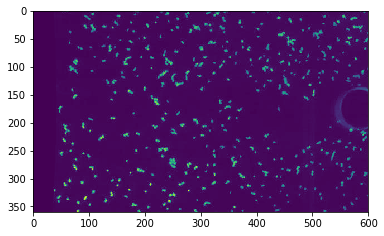

In [238]:
plt.imshow(im_gray_2[300:900,1160:1520].T)

In [239]:
# Calculate the start frame and end frame
path = '../lab_data/undis_PIV_2/'
name_list = sorted(glob.glob(path+'ImageUndistorted_*.jpg'))
start_frame = ''
end_frame = ''
for sta_num_str, end_num_str  in zip(re.findall("\d",name_list[0])[1:], re.findall("\d",name_list[-1])[1:]):
    start_frame += sta_num_str
    end_frame += end_num_str
start_frame = int(start_frame)
end_frame = int(end_frame)
print(start_frame,' to ', end_frame)

4815  to  6098


In [240]:
pair = []
particle_position = []
interval = 5
crop_size = (300, 900, 1160,1520)
sample_number = int((end_frame-start_frame+1)/interval)
print("Generate %d frame pairs." % sample_number)

raw = False
if raw:
    raw_str = 'raw'
else:
    raw_str = 'downsample'

stopwatch = 0
for i in range(sample_number):
    file_name = path + "ImageUndistorted_%d.jpg"%(start_frame+i*interval)
    data = read_lab_data(file_name)
    if raw:
        img = data[crop_size[0]:crop_size[1],crop_size[2]:crop_size[3]].T
        
    else:
        img = data[crop_size[0]:crop_size[1],crop_size[2]:crop_size[3]].T
        img_small = ndimage.interpolation.zoom(img,.5)
    
    pair.append(img_small)
    if stopwatch == 1:
        particle_position.append(np.array(pair))
        pair.pop(0)
        stopwatch = 0
    stopwatch += 1
    print("Finished ",i, " frame.") # The frame size is ", particle_position[i].shape)

ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y_%m_%d_%H_%M_%S')
output_path = "../data/lab_data/lab_data_"+ raw_str +'_'+st
os.mkdir(output_path)
np.save(output_path + "/lab_data_particle_positions", np.array(particle_position))
with open(output_path+"/Parameters.txt",'w') as file:
    file.write("Dataset size: "+ str(np.array(particle_position).shape)+"\n")

Generate 128 frame pairs.
Finished  0  frame.
Finished  1  frame.
Finished  2  frame.
Finished  3  frame.
Finished  4  frame.
Finished  5  frame.
Finished  6  frame.
Finished  7  frame.
Finished  8  frame.
Finished  9  frame.
Finished  10  frame.
Finished  11  frame.
Finished  12  frame.
Finished  13  frame.
Finished  14  frame.
Finished  15  frame.
Finished  16  frame.
Finished  17  frame.
Finished  18  frame.
Finished  19  frame.
Finished  20  frame.
Finished  21  frame.
Finished  22  frame.
Finished  23  frame.
Finished  24  frame.
Finished  25  frame.
Finished  26  frame.
Finished  27  frame.
Finished  28  frame.
Finished  29  frame.
Finished  30  frame.
Finished  31  frame.
Finished  32  frame.
Finished  33  frame.
Finished  34  frame.
Finished  35  frame.
Finished  36  frame.
Finished  37  frame.
Finished  38  frame.
Finished  39  frame.
Finished  40  frame.
Finished  41  frame.
Finished  42  frame.
Finished  43  frame.
Finished  44  frame.
Finished  45  frame.
Finished  46  fram

## Processing PIVlab data

In [ ]:
# Set parameter

path ='../data/PIVlab/txt/'
output_path = '../PIVlab/txt'

file_total_number = len(glob.glob(path+'PIVlab_*.txt'))

In [ ]:
data_holder = []
for n in range(1, file_total_number+1):
    data_holder.append(pd.read_csv(path+'PIVlab_%04d.txt'% n, skiprows=2))

In [ ]:
mat_size = (180, 300) 
def assemble(df):

    y = df['x [px]'].values
    x = df['y [px]'].values
    vx_val = df['u [px/frame]'].values
    vy_val = df['v [px/frame]'].values
    grid_x, grid_y = np.mgrid[0:mat_size[0]:1, 0:mat_size[1]:1]

    # interploate
    vx_field = griddata((x, y), vx_val, (grid_x, grid_y), method='cubic')
    vy_field = griddata((x, y), vy_val, (grid_x, grid_y), method='cubic')
    return vx_field, vy_field

In [ ]:
vx_set = []
vy_set = []
vm_set = []
scale_factor = 300.0
n = 0 
for df in data_holder:
    vx = assemble(df)[0]/scale_factor
    vy = assemble(df)[1]/scale_factor
    vx_set.append(vx)
    vy_set.append(vy)
    vm_set.append(np.power(vx*vx+vy*vy,0.5))
    n += 1
    print("%d frame Finished."%n)

In [ ]:
plt.imshow(vx_set[10])
os.mkdir(output_path)
np.save(output_path + "/vx_field", np.array(vx_set))
np.save(output_path + "/vy_field", np.array(vy_set))
np.save(output_path + "/vm_field", np.array(vm_set))